In [1]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

#Import Qiskit classes
import qiskit
from qiskit import IBMQ, pulse, QuantumCircuit, execute, transpile, Aer, assemble
from qiskit.pulse import library, Schedule, Play, ShiftPhase
from qiskit.pulse.schedule import ParameterizedSchedule
from qiskit.ignis.characterization import update_u_gates, get_single_q_pulse
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

Create function to modify the inst_map

In [2]:
# function for modify the parameters
def tune_param(params, c1):
    """  (eg) C1 = 2 = ratio to extend duration & sigma
     X pulse ==>
        inst.pulse = Drag(duration=640, amp=(0.6472753752719002+0j), sigma=160, beta=-4.631873857015726)
        inst.pulse.parameters  = {'duration': 640, 'amp': (0.6472753752719002+0j), 'sigma': 160, 'beta': -4.631873857015726}
    """
    params['sigma'] = params['sigma'] * c1
    params['amp']   = params['amp'] / c1
    params['duration'] = params['duration'] * c1
    #print(params)
    return params

In [3]:
def update_x_gates(drag_params, pi2_pulse_schedules=None,
                   qubits=None, inst_map=None, drives=None):
    """Update the cmd_def with new single qubit gate values
    Will update x
    Args:
        drag_params (list): list of drag params
        pi2_pulse_schedules (list): list of new pi/2 gate as a pulse schedule
                             will use the drag_params if this is None.
        qubits (list): list of qubits to update
        inst_map (InstructionScheduleMap): InstructionScheduleMap providing
            circuit instruction to schedule definitions.
        drives (list): List of drive chs
    """
    for qubit in qubits:

        drive_ch = drives[qubit]

        if pi2_pulse_schedules is None:
            x90_pulse = library.drag(**drag_params[qubit])
            x90_sched = Schedule()
            x90_sched += Play(x90_pulse, drive_ch).shift(0)
        else:
            x90_sched = pi2_pulse_schedules[qubit]

        pulse_dur = x90_sched.duration

        # find channel dependency for x

        _x_group = (drive_ch, )

        # add commands to schedule
        # x
        sched_components = [x90_sched]
        schedule1 = ParameterizedSchedule(*sched_components,
                                          parameters=None, name='x_%d' % qubit)



        inst_map.add('x', qubits=qubit, schedule=schedule1)

In [4]:
def mod_inst_map(inst_map_, c, qubit_):
    inst_map_copy = deepcopy(inst_map_)
    x_sched_ = inst_map_copy.get('x', qubit_)
    u2_sched_ = inst_map_copy.get('u2', qubit_, P0=1, P1=1)
    u3_sched_ = inst_map_copy.get('u3', qubit_, P0=1, P1=1, P2=1)
    print('origin parameters')
    # print(x_sched_)
    # print(u2_sched_)
    # print(u3_sched_)
    inst_u3_ = u3_sched_.instructions[2][1]
    # print(inst_u3_)
    x_params_ = x_sched_.instructions[0][1].pulse.parameters
    origin_params_ = inst_u3_.pulse.parameters
    print(x_params_)
    print(origin_params_)
    # modify the parameters
    mod_x_params_ = tune_param(x_params_, c)
    mod_params_ = tune_param(origin_params_, c)
    print('modify parameters')
    print(mod_x_params_)
    print(mod_params_)
    dri_channel = []
    for q_i in qubit_:
        dri_channel.append(pulse.DriveChannel(q_i))
    update_x_gates([mod_x_params_], None, qubit_, inst_map_copy, dri_channel)
    update_u_gates([mod_params_], None, qubit_, inst_map_copy, dri_channel)
    get_single_q_pulse(inst_map_copy, [0])

    return inst_map_copy

load account

In [5]:
IBMQ.load_account()

/home/pyserver/miniconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [6]:
# backend_real = IBMQ.providers()[0].backends(open_pulse=True)[0]
backend_real = IBMQ.providers()[1].backends.ibmq_bogota
origin_inst_map = deepcopy(backend_real.defaults().instruction_schedule_map)
# backend_real

In [7]:
origin_inst_map.get('u2', qubits=[0], P0=1, P1=1)

Schedule((0, ShiftPhase(-1.0, DriveChannel(0))), (0, ShiftPhase(-1.0, ControlChannel(1))), (0, Play(Drag(duration=160, amp=(-0.0006371499830915927+0.09754548275520072j), sigma=40, beta=0.38978502241609814), DriveChannel(0))), (160, ShiftPhase(-1.0, DriveChannel(0))), (160, ShiftPhase(-1.0, ControlChannel(1))), name="u2")

In [10]:
# check the stretched function work
# this procedure should be run for each time you change the c_j constant
new_inst_map = mod_inst_map(origin_inst_map, 3, [0])
backend_real.defaults().instruction_schedule_map = new_inst_map
# get_single_q_pulse(new_inst_map, [0])
# backend_real.configuration().num_qubits

origin parameters
{'duration': 160, 'amp': (0.1952823704554708+0j), 'sigma': 40, 'beta': -0.8873263338524642}
{'duration': 160, 'amp': (0.09754548275520072+0.0006371499830915923j), 'sigma': 40, 'beta': 0.38978502241609814}
modify parameters
{'duration': 480, 'amp': (0.06509412348515693+0j), 'sigma': 120, 'beta': -0.8873263338524642}
{'duration': 480, 'amp': (0.03251516091840024+0.00021238332769719744j), 'sigma': 120, 'beta': 0.38978502241609814}


In [ ]:
#Number of qubits
nQ = 1
#There are 3 qubits: Q0,Q1,Q2.
#Number of seeds (random sequences)
nseeds = 10
#Number of Cliffords in the sequence (start, stop, steps)
nCliffs = np.arange(1,100,5)
#2Q RB on Q0,Q2 and 1Q RB on Q1
rb_pattern = [[0]]
#Do three times as any 1Q Cliffords
length_multiplier = 1

rb_opts = {'length_vector': nCliffs,
           'nseeds': nseeds,
           'rb_pattern': rb_pattern,
           'length_multiplier': length_multiplier,
           'group_gates': 'Clifford'}
rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

# rb_circs[0][0].draw(output='mpl')

# #Create a new circuit without the measurement
# qc = qiskit.QuantumCircuit(*rb_circs[0][-1].qregs,*rb_circs[0][-1].cregs)
# for i in rb_circs[0][-1][0:-nQ]:
#     qc.data.append(i)

#
# #The Unitary is an identity (with a global phase)
# backend = qiskit.Aer.get_backend('unitary_simulator')
# basis_gates = ['u1', 'u2', 'u3', 'cx'] # use U,CX for now
# job = qiskit.execute(qc, backend=backend, basis_gates=basis_gates)
# print(np.around(job.result().get_unitary(), 3))

# noise_model = NoiseModel()
# p1Q = 0.002
# p2Q = 0.01
# noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
# noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
# noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

c_list = [1, 2, 3]
shots = 4096
transpiled_circs_list = []
ydata = []
for ci in c_list:
    print('Cj = ', ci)
    temp_inst_map = mod_inst_map(origin_inst_map, ci, [0])
    backend_real.defaults().instruction_schedule_map = temp_inst_map

    # Create the RB fitter
    # backend = qiskit.Aer.get_backend('qasm_simulator')
    # basis_gates = ['u1','u2','u3','cx']

    transpiled_circs_list = []
    ydata_temp = []
    rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])
    for rb_seed, rb_circ_seed in enumerate(rb_circs):
        print('Compiling seed %d'%rb_seed)
        new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, backend_real, optimization_level=0, initial_layout=[0])
        for i in range(nseeds):
            transpiled_circs_list.append(new_rb_circ_seed[i])
        print('Simulating seed %d'%rb_seed)
        rb_sceldule = qiskit.schedule(new_rb_circ_seed, backend_real)
        job = qiskit.execute(rb_sceldule, backend_real, shots=shots)
        # Add data to the fitter
        rb_fit.add_data(job.result())
        print('After seed %d, alpha: %f, EPC: %f'%(rb_seed,rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))
        ydata_temp.append(rb_fit.ydata[0]['mean'])
    ydata.append(ydata_temp)

Cj =  1
origin parameters
{'duration': 160, 'amp': (0.1952823704554708+0j), 'sigma': 40, 'beta': -0.8873263338524642}
{'duration': 160, 'amp': (0.09754548275520072+0.0006371499830915923j), 'sigma': 40, 'beta': 0.38978502241609814}
modify parameters
{'duration': 160, 'amp': (0.1952823704554708+0j), 'sigma': 40, 'beta': -0.8873263338524642}
{'duration': 160, 'amp': (0.09754548275520072+0.0006371499830915923j), 'sigma': 40, 'beta': 0.38978502241609814}
Compiling seed 0
Simulating seed 0


/home/pyserver/miniconda3/lib/python3.8/site-packages/qiskit/compiler/assemble.py:320: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  warnings.warn(


In [ ]:
plt.figure(figsize=(8, 6), facecolor='w')
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rb_fit.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)

# Add title and label
ax.set_title('%d Qubit RB'%(nQ), fontsize=18)

plt.show()

In [ ]:
c_list = [1, 2]
print('c = ', c_list)

def gamma_j(c_list_):
    gamma_list = []
    for j in range(len(c_list_)):
        gamma_temp = 1
        for m_a in range(j):
            gamma_temp *= c_list_[m_a]/(c_list_[j]-c_list_[m_a])
        for m_b in range(len(c_list_)-j-1):
            gamma_temp *= c_list_[m_b+j+1]/(c_list_[j]-c_list_[m_b+j+1])
        gamma_list.append(gamma_temp)
    # if len(c_list_)%2==0:
        # gamma_list *= (-1)
    return gamma_list
gamma_list = gamma_j(c_list)
print(gamma_list)

print('check constraints')
print('j from 0 to n = ', len(c_list)-1)
print('Summation of gamma_j = ',sum(gamma_list))
rc = 0
for k in range(len(c_list)-1):
    for i in range(len(gamma_list)):
        rc += c_list[i]**(k+1)*gamma_list[i]
print('Summation of gamma_j * c_j**(from 1 to n) = ', rc)

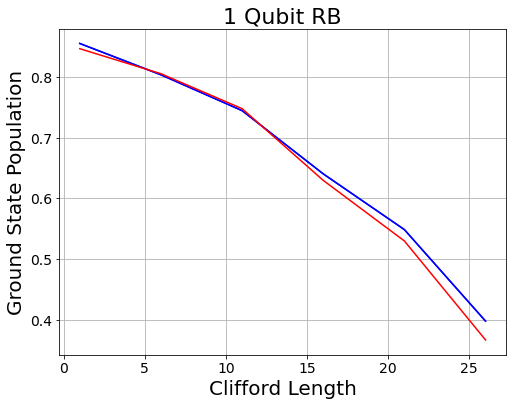

In [432]:
plt.figure(figsize=(8, 6), facecolor='w')
plt.title('%d Qubit RB'%(nQ), fontsize=22)
plt.xlabel('Clifford Length', fontsize=20)
plt.ylabel('Ground State Population', fontsize=20)
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')
plt.grid()
for i in range(len(c_list)):
    plt.plot(xdata[0][0: 6], ydata[1][2][0: 6], 'b')
plt.plot(xdata[0][0: 6], 2*ydata[0][2][0: 6]-ydata[1][2][0: 6], 'r')
# plt.plot(xdata[0], 3*ydata[0][1]-3*ydata[1][1]+ydata[2][1])
# plt.savefig('Richardson_RB_result.jpg', dpi=150)
plt.show()